In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import rioxarray as rxa

import matplotlib.pyplot as plt

from uavsar_pytools.snow_depth_inversion import phase_from_depth, depth_from_phase

from constants import tol

ncs_dir = Path('/bsuhome/zacharykeskinen/scratch/data/uavsar/ncs')
ds = xr.open_dataset(ncs_dir.joinpath('final_10_10.nc'))#.isel(x = slice(0, -1, 10), y = slice(0, -1, 10))

ds = ds.where(ds['cor'] > 0.45)

interval = pd.read_parquet('/bsuhome/zacharykeskinen/uavsar-validation/data/insitu/storm_boards.parq')
interval = gpd.GeoDataFrame(interval, geometry = gpd.points_from_xy(interval.longitude, interval.latitude), crs="EPSG:4326")

In [2]:
insitu = pd.read_parquet('/bsuhome/zacharykeskinen/uavsar-validation/data/insitu/all_difference.parq')
insitu = insitu[insitu.site_name != 'jackson']
insitu = gpd.GeoDataFrame(insitu, geometry = gpd.points_from_xy(insitu.lon, insitu.lat), crs="EPSG:4326")

# get insitu info
densities = np.zeros(len(ds.time1.data))
phases = np.zeros(len(ds.time1.data))
for i, time in enumerate(ds.time1.data):
    insitu_t = insitu[insitu.time1 == time]
    density = np.mean(insitu_t[['t1_density', 't2_density']].mean(axis = 1))
    densities[i] = density
    phases[i] = np.mean(phase_from_depth(insitu_t['dSWE']*997/density, insitu_t['inc'], density = insitu_t[['t1_density', 't2_density']].mean(axis = 1)))
densities = xr.DataArray(densities,
    coords = {'time1':ds.time1.data})
phases = xr.DataArray(phases,
    coords = {'time1':ds.time1.data})

ds['unw_atm'] = ds['unw'] - ds['delay']
ds['unw_atm'] = ds['unw_atm'] - (ds['unw_atm'].mean(dim = ['x','y']) - phases)
# ds['unw_atm'] = sub['unw_atm'] - (sub['unw_atm'].mean(dim = ['x','y']) - sub['model_d_swe'].mean(dim = ['x','y']))
unw_d_swe = depth_from_phase(ds['unw_atm'], ds['inc'], density = densities) * densities / 997
unw_d_sd = depth_from_phase(ds['unw_atm'], ds['inc'], density = densities)

In [3]:
for i, r in interval.iterrows():
    try:
        uv_t = unw_d_swe.sel(time1 = r.date_t1, method = 'nearest', tolerance = '3 days')
        uv_t_sd = unw_d_sd.sel(time1 = r.date_t1, method = 'nearest', tolerance = '3 days')
        ds_t = ds.sel(time1 = r.date_t1, method = 'nearest', tolerance = '3 days')
    except KeyError:
        continue

    interval.loc[i, 'near_uv_swe'] = uv_t.sel(x = r.geometry.x, y = r.geometry.y, method = 'nearest', tolerance = tol)
    interval.loc[i, 'near_uv_sd'] = uv_t_sd.sel(x = r.geometry.x, y = r.geometry.y, method = 'nearest', tolerance = tol)
    x_slice = slice(r.geometry.x - 2*tol, r.geometry.x + 2*tol)
    y_slice = slice(r.geometry.y + 2*tol, r.geometry.y - 2*tol)
    interval.loc[i, 'uv_swe'] = uv_t_sd.sel(x = x_slice, y = y_slice).mean() * r.den / 997
    interval.loc[i, 'uv_sd'] = uv_t_sd.sel(x = x_slice, y = y_slice).mean()
    interval.loc[i, 'model_melt'] = ds_t.sel(x = x_slice, y = y_slice)['cum_melt'].mean()
    interval.loc[i, 'cor'] = ds_t.sel(x = x_slice, y = y_slice)['cor'].mean()
    interval.loc[i, 'tree'] = ds_t.sel(x = x_slice, y = y_slice)['tree_perc'].mean()

(-0.04, 0.07)

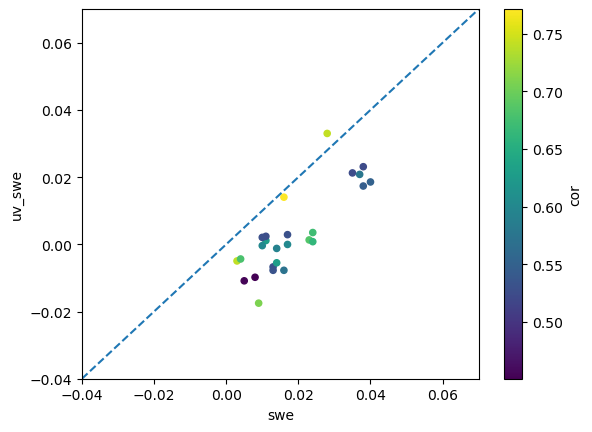

In [4]:
interval[(interval.site.str.contains('LR')) & (interval.swe > 0)].plot.scatter(x = 'swe', y = 'uv_swe', c = 'cor')
plt.plot([-0.04, 0.12],[-0.04, 0.12], linestyle = 'dashed')
plt.xlim(-0.04, 0.07)
plt.ylim(-0.04, 0.07)

<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


KeyboardInterrupt: 

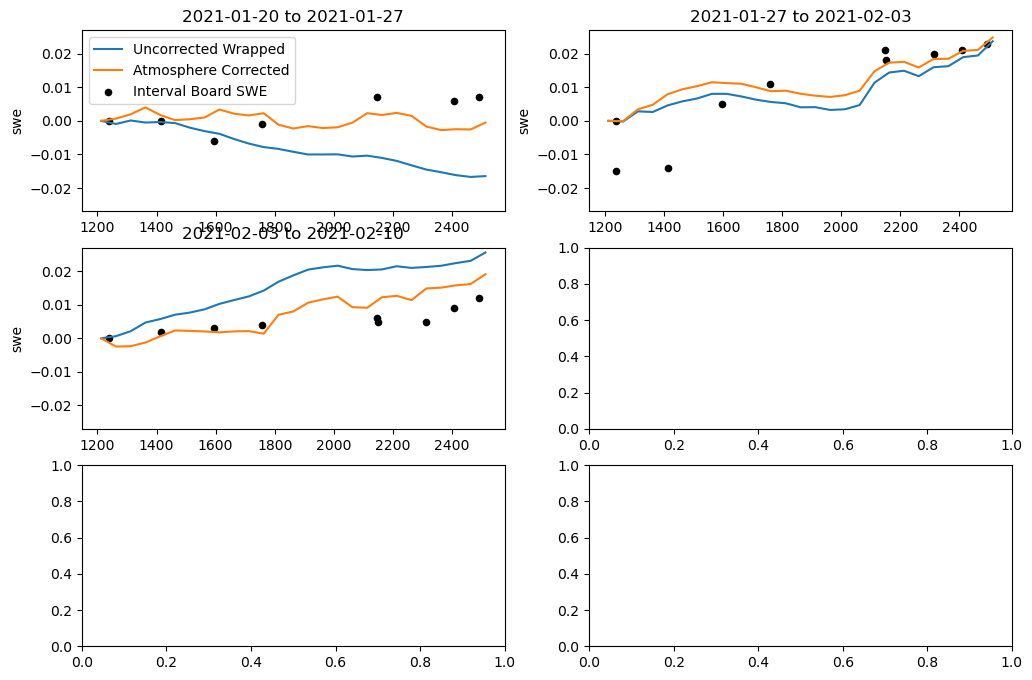

In [5]:
from shapely.geometry import LineString
# set up datasets
ds = xr.open_dataset(ncs_dir.joinpath('final_insitu.nc'))#final_insitu final_10_10
ds = ds.rio.write_crs('EPSG:4326')
insitu = pd.read_parquet('/bsuhome/zacharykeskinen/uavsar-validation/data/insitu/all_difference.parq')
insitu = insitu[insitu.site_name != 'jackson']
insitu = gpd.GeoDataFrame(insitu, geometry = gpd.points_from_xy(insitu.lon, insitu.lat), crs="EPSG:4326")

# get insitu info
densities = np.zeros(len(ds.time1.data))
phases = np.zeros(len(ds.time1.data))
for i, time in enumerate(ds.time1.data):
    insitu_t = insitu[insitu.time1 == time]
    density = np.mean(insitu_t[['t1_density', 't2_density']].mean(axis = 1))
    densities[i] = density
    phases[i] = np.mean(phase_from_depth(insitu_t['dSWE']*997/density, insitu_t['inc'], density = insitu_t[['t1_density', 't2_density']].mean(axis = 1)))
densities = xr.DataArray(densities,
    coords = {'time1':ds.time1.data})
phases = xr.DataArray(phases,
    coords = {'time1':ds.time1.data})

# ds['int_swe_not'] = depth_from_phase(ds['int_phase'] - (ds['int_phase'].mean(dim = ['x','y']) - phases), ds['inc'],  density = densities) * densities / 997

# ds['int_atm'] = ds['int_phase'] - ds['delay']
# ds['int_atm'] = ds['int_atm'] - (ds['int_atm'].mean(dim = ['x','y']) - phases)
# ds['int_swe'] = depth_from_phase(ds['int_atm'] - (ds['int_atm'].mean(dim = ['x','y']) - phases), ds['inc'],  density = densities) * densities / 997


fig, axes = plt.subplots(3, 2, figsize = (12, 8))
site_id = 'LR'
boards = interval[interval.site.str.contains(site_id)]
boards = boards.sort_values('elev_meters')

boards = boards[['swe','elev_meters','date_t2','date_t1','geometry']]

i = 0
for t1, t2 in zip(ds.time1.data, ds.time2.data):
    flight_boards = boards.loc[(boards.date_t2 <= t2 + pd.Timedelta('2 days')) & (boards.date_t1 >= t1 - pd.Timedelta('2 days')), :].copy()
    flight_boards = flight_boards.dropna()
    xmin, ymin, xmax, ymax = flight_boards.total_bounds
    ds_site = ds.sel(x = slice(xmin, xmax), y = slice(ymax, ymin), time1 = t1, time = t1)
    ds_site = ds_site[['dem','int_phase', 'cor','delay','inc','model_melt']]
    if ds_site.x.size > 1 and ds_site.y.size > 1 and len(flight_boards) > 3:
        site_phase = phases.sel(time1 = t1)
        site_densities = densities.sel(time1 = t1)
        ds_site['int_swe_not'] = depth_from_phase(ds_site['int_phase'], ds_site['inc'],  density = site_densities) * site_densities / 997
        ds_site['int_atm'] = ds_site['int_phase'] - ds_site['delay']
        ds_site['int_atm'] = ds_site['int_atm'] - (ds_site['int_atm'].mean(dim = ['x','y']) - site_phase)
        ds_site['int_swe'] = depth_from_phase(ds_site['int_atm'], ds_site['inc'],  density = site_densities) * site_densities / 997
        
        geom = []
        for g1, g2 in zip(flight_boards.geometry.iloc[:-1], flight_boards.geometry.iloc[1:]):
            geom.append(LineString([g1, g2]))
        buffer = gpd.GeoDataFrame({'geometry':geom})
        buffer = buffer.buffer(10*tol)

        ds_site = ds_site.rio.clip(buffer.geometry.values, crs= 'EPSG:4326')
        
        ds_site = ds_site[['int_swe','dem','cor','int_swe_not', 'model_melt']]#.where(ds_site['cor'] > 0.5)
        
        elev_ds = ds_site.groupby_bins('dem', np.arange(flight_boards.elev_meters.min() - 50, flight_boards.elev_meters.max() + 250, 50))

        elev_phase = elev_ds.mean()
        # elev_phase_var = elev_ds.std()['int_swe']

        ax = axes.ravel()[i]

        # elev_phase['model_melt'].plot(ax = ax, color = 'red', label = 'Model Melt')
        
        elev_phase = elev_phase - elev_phase.isel(dem_bins = 0)

        elev_phase['int_swe_not'].plot(ax = ax, color = 'C0', label = 'Uncorrected Wrapped')
        elev_phase['int_swe'].plot(ax = ax, color = 'C1', label = 'Atmosphere Corrected')
        # elev_phase = elev_phase.dropna(dim = 'dem_bins')
        # elev_phase_var = elev_phase_var.dropna(dim = 'dem_bins')
        # ax.fill_between([v.mid for v in elev_phase.dem_bins.values], (elev_phase - elev_phase_var).data, (elev_phase + elev_phase_var).data, color = 'red', alpha = 0.5, label = 'Wrapped Phase')
        flight_boards['swe'] = flight_boards['swe'] - flight_boards['swe'].iloc[0]
        if i == 0:
            flight_boards.plot.scatter(x = 'elev_meters', y = 'swe', ax = ax, label = 'Interval Board SWE', color = 'black')
            ax.legend(loc = 'upper left')
        else:
            flight_boards.plot.scatter(x = 'elev_meters', y = 'swe', ax = ax, color = 'black')
        t1, t2 = pd.to_datetime(t1), pd.to_datetime(t2)
        # ax.set_title(f"{site_id} @ {t1.strftime('%Y-%m-%d')} to {t2.strftime('%Y-%m-%d')}")
        ax.set_title(f"{t1.strftime('%Y-%m-%d')} to {t2.strftime('%Y-%m-%d')}")

        ax.set_xlabel('')
        ax.set_ylim(-0.027, 0.027)
        i += 1

for ax in axes.ravel():
    ax.set_ylabel('')

for ax in axes[:, 0]:
    ax.set_ylabel('Orographic SWE Change (m)')

plt.suptitle('Banner Study Site Orographic Trends')
plt.tight_layout()
plt.savefig('/bsuhome/zacharykeskinen/uavsar-validation/figures/interval/lowman_orographic_v2.png')

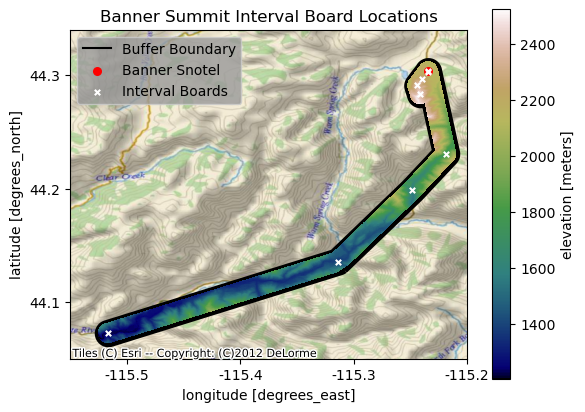

In [6]:
import contextily as ctx
fig, ax = plt.subplots()

t1 = pd.to_datetime('2021-02-03')
t2 = pd.to_datetime('2021-02-10')
flight_boards = boards.loc[(boards.date_t2 <= t2 + pd.Timedelta('2 days')) & (boards.date_t1 >= t1 - pd.Timedelta('2 days')), :].copy()
geom = []
for g1, g2 in zip(flight_boards.geometry.iloc[:-1], flight_boards.geometry.iloc[1:]):
    geom.append(LineString([g1, g2]))
buffer = gpd.GeoDataFrame({'geometry':geom})
buffer = buffer.buffer(10*tol)

gpd.GeoSeries(buffer.unary_union).plot(color = None, edgecolor='k', linewidth = 5, facecolor = None, ax = ax)
plt.plot([0,0],[0,0], color = 'k', label = 'Buffer Boundary')

ds['dem'].rio.clip(buffer.geometry.values, crs= 'EPSG:4326').plot(ax = ax, cmap = 'gist_earth', add_colorbar = True)

x, y = insitu[insitu['site_name'] == 'Banner Snotel'].iloc[0].geometry.xy
ax.scatter(x, y, label = 'Banner Snotel', color = 'red', s = 30)

flight_boards.plot(ax = ax, marker = 'x', color = 'white', markersize = 15, label = 'Interval Boards')

ax.set_xlim(-115.55, -115.2)
ax.set_ylim(44.05, 44.34)
ax.set_xticks([-115.5, -115.4, -115.3, -115.2], ['-115.5', '-115.4', '-115.3', '-115.2'])
ax.set_yticks([44.1, 44.2, 44.3], ['44.1', '44.2', '44.3'])

ax.legend(loc = 'upper left', facecolor = '0.6')
ctx.add_basemap(ax = ax, crs = 'EPSG:4326', source= ctx.providers.Esri.DeLorme, zoom = 11)
ax.set_title('Banner Summit Interval Board Locations')
plt.savefig('/bsuhome/zacharykeskinen/uavsar-validation/figures/interval/lowman_orographic_map_v2.png')

<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


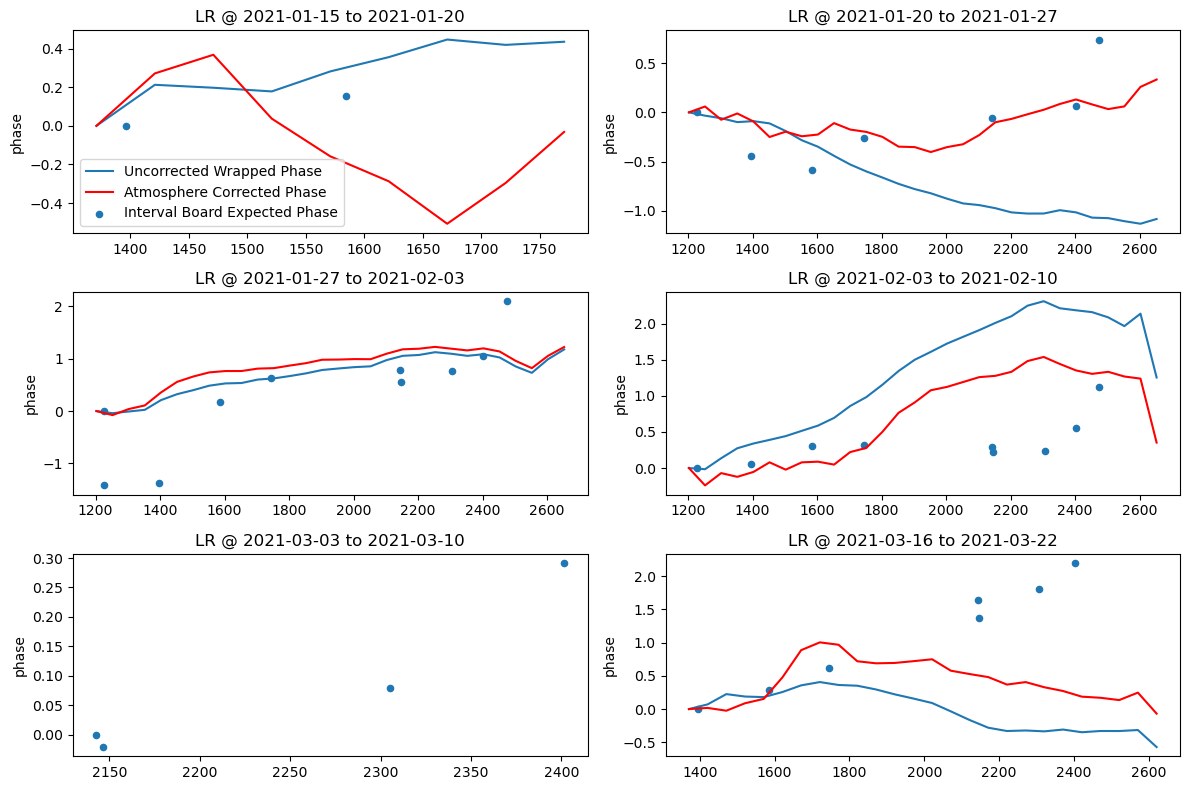

In [ ]:
data_dir = Path('/bsuhome/zacharykeskinen/uavsar-validation/data')
insitu_dir = data_dir.joinpath('insitu')
insitu = pd.read_parquet(insitu_dir.joinpath('all_insitu.parq'))
boards = pd.read_parquet(insitu_dir.joinpath('storm_boards.parq'))
boards = gpd.GeoDataFrame(boards, geometry=gpd.points_from_xy(boards.longitude, boards.latitude), crs="EPSG:4326")
# add inc
for i, r in boards.iterrows():
    boards.loc[i, 'inc'] = ds.sel(x = r.geometry.x, y = r.geometry.y, method = 'nearest')['inc'].data.ravel()[0]
    boards.loc[i, 'elev'] = ds.sel(x = r.geometry.x, y = r.geometry.y, method = 'nearest')['dem'].data.ravel()[0]

interval_dir = Path('/bsuhome/zacharykeskinen/uavsar-validation/figures/interval')

fig, axes = plt.subplots(3, 2, figsize = (12, 8))
i = 0
for t1, t2 in zip(ds.time1.data, ds.time2.data):
    flight_boards = boards.loc[(boards.date_t2 <= t2 + pd.Timedelta('2 days')) & (boards.date_t1 >= t1 - pd.Timedelta('2 days')), :].copy()
    # for site_id in ['BB','LR', 'MC']:
    site_id = 'LR'
    flight_boards_site = flight_boards.loc[flight_boards.site.str.contains(site_id), :].copy()
    flight_boards_site = flight_boards_site.dropna(subset=['hn','den','inc'])
    xmin, ymin, xmax, ymax = flight_boards_site.total_bounds
    ds_site = ds.sel(x = slice(xmin, xmax), y = slice(ymax, ymin), time1 = t1)
    # ds_site = ds_site.rolling(x = 5, y =5).mean()
    # ds_site = ds_site.where((ds_site['cor'] > 0.3))
    if ds_site.x.size > 1 and ds_site.y.size > 1 and len(flight_boards_site) > 1 and ds_site['int_phase'].isnull().sum() != ds_site['int_phase'].size:
        if i > 15:
            print('More than 8 subplots')
            break
        flight_boards_site = flight_boards_site.sort_values('elev')

        board_phase = phase_from_depth(flight_boards_site.hn.values, inc_angle=flight_boards_site.inc.values, density = flight_boards_site.den.values)
        board_phase = board_phase - board_phase[0]

        flight_boards_site.loc[:, 'phase'] = board_phase

        elev_phase = ds_site.groupby_bins('dem', np.arange(flight_boards_site.elev.min()-50, flight_boards_site.elev.max() + 250, 50)).mean()
        elev_phase = elev_phase - elev_phase.isel(dem_bins = 0)
        # elev_phase = elev_phase.rolling({'dem_bins': 3}, min_periods=1).mean()

        ax = axes.ravel()[i]
        elev_phase['int_phase'].plot(ax = ax, label = 'Uncorrected Wrapped Phase')
        (elev_phase['int_phase'] - elev_phase['delay']).plot(ax = ax, color = 'red', label = 'Atmosphere Corrected Phase')

        if i == 0:
            flight_boards_site.plot.scatter(x = 'elev', y = 'phase', ax = ax, label = 'Interval Board Expected Phase')
            ax.legend()
        else:
            flight_boards_site.plot.scatter(x = 'elev', y = 'phase', ax = ax)
        t1, t2 = pd.to_datetime(t1), pd.to_datetime(t2)
        ax.set_title(f"{site_id} @ {t1.strftime('%Y-%m-%d')} to {t2.strftime('%Y-%m-%d')}")
        ax.set_xlabel('')
        i += 1
plt.tight_layout()